## Loading the dataset from drive

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
# Import the zipfile library
import zipfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Get the path to the zip file
zip_file_path = '/content/gdrive/My Drive/AML_Assignment1/sp500_tickers_AD_1min_1pppix.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
  zip_file.extractall('/content/my_unzipped_folder')


Mounted at /content/gdrive


In [5]:
# Get the path to the folder containing the .txt files
folder_path = '/content/my_unzipped_folder/sp500_tickers_A-D_1min_1pppix/AAL_1min.txt'

## Familiarizing myself with the data

### Printing the dataframe

In [16]:
data = pd.read_csv(folder_path)[:]
df = pd.DataFrame(data,)
df.columns =["date_time", "Open", "High", "Low", "Close", "Volume"]

# Convert the date_time column to a datetime dtype
df.index = pd.to_datetime(df['date_time'])

print(df)

                               date_time     Open     High      Low    Close  \
date_time                                                                      
2013-12-09 08:37:00  2013-12-09 08:37:00  22.6258  22.6258  22.5787  22.5787   
2013-12-09 08:38:00  2013-12-09 08:38:00  22.3901  22.3901  22.3901  22.3901   
2013-12-09 08:39:00  2013-12-09 08:39:00  22.1544  22.1544  22.1544  22.1544   
2013-12-09 08:40:00  2013-12-09 08:40:00  22.3430  22.3430  22.3335  22.3335   
2013-12-09 08:41:00  2013-12-09 08:41:00  22.3335  22.3335  22.3335  22.3335   
...                                  ...      ...      ...      ...      ...   
2022-02-25 19:54:00  2022-02-25 19:54:00  17.4700  17.4700  17.4700  17.4700   
2022-02-25 19:55:00  2022-02-25 19:55:00  17.4700  17.4900  17.4700  17.4900   
2022-02-25 19:57:00  2022-02-25 19:57:00  17.4800  17.4900  17.4800  17.4900   
2022-02-25 19:58:00  2022-02-25 19:58:00  17.4800  17.4900  17.4799  17.4900   
2022-02-25 19:59:00  2022-02-25 19:59:00

This is the dataframe containing the stock dataset min-by-min

### Plotting minute by minute

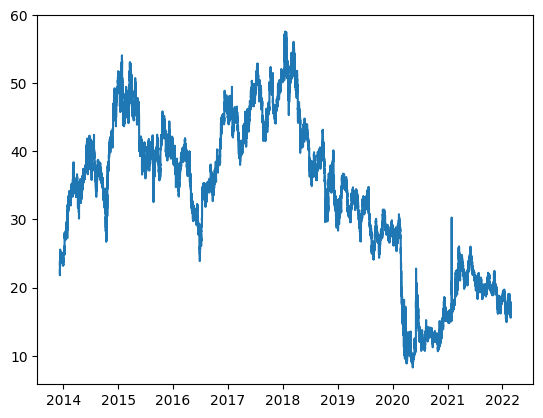

In [17]:
#Plotting datetime vs closing value
plt.plot(df.index, df['Close'])

Plotting the dataset min-by-min

In [8]:
# To get the day by day dataset
df_day = df.groupby(df['date_time'].dt.strftime('%Y/%m/%d'))['Close'].agg(['last']).reset_index()
#Setting this dataset's indexes as date_time too
df_day.index = pd.to_datetime(df_day['date_time'])

df_day.drop(['date_time'], axis = 1, inplace = True)

## Creating a day by day dataframe

               last
date_time          
2013-12-09  23.2386
2013-12-10  23.4743
2013-12-11  24.5113
2013-12-12  24.1813
2013-12-13  24.6527
...             ...
2022-02-18  17.7500
2022-02-22  17.5600
2022-02-23  16.5500
2022-02-24  16.7500
2022-02-25  17.4900

[2069 rows x 1 columns]


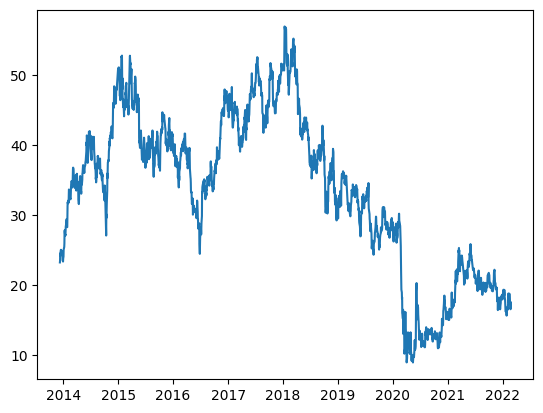

In [9]:
#Printing the day by day dataset and plotting it
print(df_day)
plt.plot(df_day.index, df_day['last'])

In [10]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00


## Creating a candlestick plot using matplotlibfinance

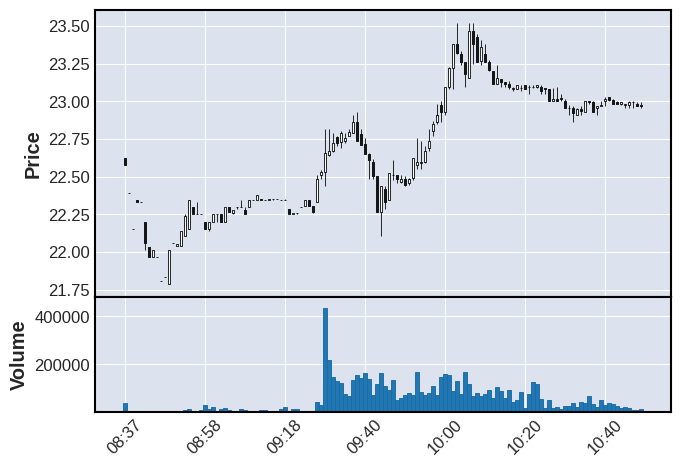

In [18]:
import mplfinance as mpf

# Create the candlestick chart
mpf.plot(df[:130], type = 'candle', volume = True)

Candle plot for the min-by-min dataset

## Describing the day by day data processed so far

In [19]:
df_day.describe()

,last
count,2069.000000
mean,33.445775
std,11.411644
min,8.940000
25%,24.794100
50%,35.240200
75%,41.860700
max,56.969200


We can see that this data is not normalized and we will be using minmax scaling to normalize this dataset

Another method for Normalizing can be log normalization that is
$y = log(x)$

In [20]:
norm_dat = pd.DataFrame(np.log(df_day.values))
norm_dat.describe()

,0
count,2069.000000
mean,3.435474
std,0.414482
min,2.190536
25%,3.210606
50%,3.562187
75%,3.734347
max,4.042511


What we can get after log normalization

We will be using z-score normalization as it is easy to implement and usefull
along with minmax() scaling

In [21]:
#Importing pytorch
import torch
import torch.nn as nn
from copy import deepcopy as dc

# Defining a function to prepare data for lstms
def prepare_dataframe_for_lstm(df, n_steps):
  dff = dc(df)
  for i in range(1, n_steps+1):
    dff[f'last(t-{i})'] = dff['last'].shift(i)
  dff.dropna(inplace=True)
  return dff
#How far we are looping to predict
lookback = 10
shifted_df = prepare_dataframe_for_lstm(df_day, lookback)
# shifted_df.drop(['High', 'Low', 'Volume'], axis = 1, inplace = True)
shifted_df

,last,last(t-1),last(t-2),last(t-3),last(t-4),last(t-5),last(t-6),last(t-7),last(t-8),last(t-9),last(t-10)
date_time,,,,,,,,,,,
2013-12-23,24.6244,24.9355,24.7941,24.7281,24.6244,25.0486,24.6527,24.1813,24.5113,23.4743,23.2386
2013-12-24,24.7470,24.6244,24.9355,24.7941,24.7281,24.6244,25.0486,24.6527,24.1813,24.5113,23.4743
2013-12-26,24.5490,24.7470,24.6244,24.9355,24.7941,24.7281,24.6244,25.0486,24.6527,24.1813,24.5113
2013-12-27,23.5685,24.5490,24.7470,24.6244,24.9355,24.7941,24.7281,24.6244,25.0486,24.6527,24.1813
2013-12-30,23.3611,23.5685,24.5490,24.7470,24.6244,24.9355,24.7941,24.7281,24.6244,25.0486,24.6527
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,17.7500,18.1900,18.7400,18.7799,17.4500,17.6000,18.5200,18.8000,18.3000,17.3500,16.4700
2022-02-22,17.5600,17.7500,18.1900,18.7400,18.7799,17.4500,17.6000,18.5200,18.8000,18.3000,17.3500
2022-02-23,16.5500,17.5600,17.7500,18.1900,18.7400,18.7799,17.4500,17.6000,18.5200,18.8000,18.3000


This part was influenced by a youtube video on using pytorch for stock prediction https://www.youtube.com/watch?v=q_HS4s1L8UI

Now we will try to add days. That is 'Monday, Tuesday and so on' as numbers so that the model can comprehend it.

In [22]:
#dict_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
#shifted_df['day'] = shifted_df.index.day_name()
#shifted_df['day'].replace(dict_map, inplace = True)
#shifted_df

This code snippet can be used to add a day column to the dataset for making predictions with more information

In [23]:
#Splitting the data in
split_index = np.where(shifted_df.index.year == 2020)[0][0]
split_index

1516

this will be the splitting index for our data.

## Scaling the dataset using minmax scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))
shifted_df = scaler.fit_transform(shifted_df.values)

## Transforming from dataframe to workable tensors

In [25]:
#Preparing the data by converting it to numpy
X = shifted_df[:, 1:]
y = shifted_df[:, 0] # As we are going to predict only the closing values

X.shape, y.shape

((2059, 10), (2059,))

In [26]:
#Now we want the time to go in a decending manner so that the prediction nows the
#the coming value is closest to the predicted one
X = dc(np.flip(X, axis = 1))
X.shape

(2059, 10)

In [27]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1516, 10), (543, 10), (1516,), (543,))

In [28]:
#Since LSTMs require another dimensions to keep track of the sequence we will have
#add another dimension

X_train = X_train.reshape((-1, lookback, 1)) #To account for 5 features
X_test = X_test.reshape((-1, lookback, 1))  #To account for 5 features

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1516, 10, 1), (543, 10, 1), (1516, 1), (543, 1))

In [29]:
#Wrapping all the data in pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_test = torch.tensor(X_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1516, 10, 1]),
 torch.Size([543, 10, 1]),
 torch.Size([1516, 1]),
 torch.Size([543, 1]))

## Dataset

Generally when training models in pytorch. We use datasets rather than just raw tensors. So we will have to make out down dataset for this

In [30]:
from torch.utils.data import Dataset

#Creating dataset function for wrapping up the pytorch tensors in a format which could then be loaded using dataloaders

class TimeSeriesDataset(Dataset):
  # Initializes .X and .y for input and output
  def __init__(self, X, y):
    self.X = X
    self.y = y
  #Function to get the length of the input
  def __len__(self):
    return len(self.X)
  #To retrive the element stored at ith position
  def __getitem__(self, i):
    return self.X[i], self.y[i]
#Creating the datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)


## DataLoaders

In [31]:
# Now after wrapping the tensors in dataset we then wrap them in dataloaders
from torch.utils.data import DataLoader
# Creating out dataset
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
#Since we don't want suffling to happen with the test dataset
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Reference:
https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

In [32]:
#Setting the device which will be used for creating the batches
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

This code is to let the model know if the gpu(cuda:0) is available or not.


## Creating batches

In [33]:
#Creating batches
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape) # We are expecting the a batch size of 16 with 7 lookback windows
  break                               # While for y_batch it should contain 16 examples containing just one value


torch.Size([30, 10, 1]) torch.Size([30, 1])


We can see that the expected shape is observed when printed for the batches created using the dataloaders

## Finally we are gonna define a LSTM class using pytorch

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_d
        # Sequence of hidden layers which are stacked on top of each other
        # That is that it takes the input from the lstm prior to it and sends its own output to the next state
        self.layer_dim = layer_d # The more of these things that you have the more complexity your model has

        # LSTM model
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True)
        # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Output_d can be one if we want to predict
        # the final closing value or more if we want to predict other metrics as well
        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        #Batch size  = x.size[0]
        #Hidden gate's output
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        #Central stage values
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        #Output observed and the updated tuple (hn, cn)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #Extracting output values
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1 # Number of features (Like closing value, opening values and so)
hidden_dim = 14 # The dimensions which we want in the middle there
output_dim = 1
layer_dim = 2

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)
model

LSTMModel(
  (lstm): LSTM(1, 14, num_layers=2, batch_first=True)
  (fc): Linear(in_features=14, out_features=1, bias=True)
)

We can see that the model that we just created is stored as a pytorch model

Creating the training loop

## Defining training functions

In [35]:
#Creating a training function
def train_1epoch():
  model.train(True) # Set the model in training mode
  print(f'Epoch: {epoch + 1}') # Print the epoch
  running_loss = 0.0 # Start to accumulate this running loss

  for batch_index, batch in enumerate(train_loader): #Loop over the train loader
    x_batch, y_batch = batch[0].to(device), batch[1].to(device) # From the batch extract X and Y values

    output = model(x_batch) # From the model get the output
    loss = loss_function(output, y_batch) # Generating the loss by comparing model's output to the ground truth
    running_loss += loss.item()

    optimizer.zero_grad() #Sets the gradients of all optimized torch.Tensor s to zero
    loss.backward() # backwards pass through the loss to calculate the grad
    optimizer.step() # Taking a small step to better out our model

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))

      running_loss = 0.0
  print()

In [36]:
#Creating a validate function
def validate_1epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch.float())
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val loss: {0:.3f}'.format(avg_loss_across_batches))
  print('*************************************************')
  print()

## Training loop

In [37]:
# Using normal ML training loop with learning_rates and all
learning_rate = 0.001
num_epoch = 70
# We use the mean square error to calculate the loss since it is still a regression problem
loss_function = nn.MSELoss()
# We will be using ADAM optimizer for this training method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epoch):
  train_1epoch() #As defined above
  validate_1epoch() #As defined above

Epoch: 1

Val loss: 0.824
*************************************************

Epoch: 2

Val loss: 0.517
*************************************************

Epoch: 3

Val loss: 0.224
*************************************************

Epoch: 4

Val loss: 0.185
*************************************************

Epoch: 5

Val loss: 0.157
*************************************************

Epoch: 6

Val loss: 0.130
*************************************************

Epoch: 7

Val loss: 0.117
*************************************************

Epoch: 8

Val loss: 0.102
*************************************************

Epoch: 9

Val loss: 0.094
*************************************************

Epoch: 10

Val loss: 0.085
*************************************************

Epoch: 11

Val loss: 0.083
*************************************************

Epoch: 12

Val loss: 0.075
*************************************************

Epoch: 13

Val loss: 0.069
**********************************************

Since our model has already seen this data it is able to predict it very nicely.

Although this data is scaled so now lets convert it back to its initial state

## Plotting our findings for the same

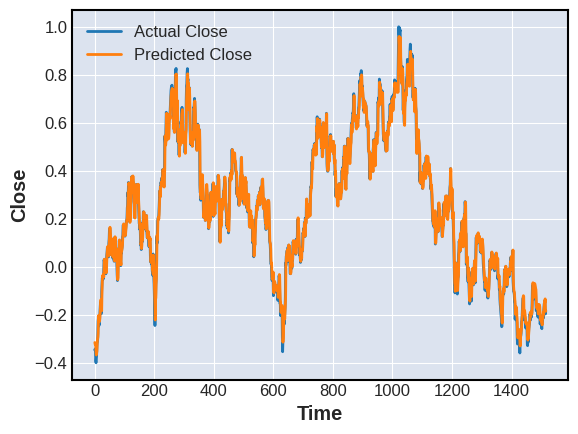

In [38]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [39]:
train_predictions = predicted.flatten()
# For X train we calculate the inverse transfrom of scaler
x = np.zeros((X_train.shape[0], lookback+1))
x[:,0] = train_predictions
x = scaler.inverse_transform(x)

train_predictions = dc(x[:,0])
train_predictions

array([25.38841294, 25.20605849, 25.24277558, ..., 29.75376499,
       28.74087707, 28.51076636])

In [40]:
x = np.zeros((X_train.shape[0], lookback+1))
x[:,0] = y_train.flatten() # first columns is gonna be the y_train
x = scaler.inverse_transform(x) #Converting it back to its initial position

new_y_train = dc(x[:, 0]) # storing the deepcopy of the updated first column
new_y_train

array([24.62440007, 24.74700006, 24.54899989, ..., 28.26549982,
       28.24560004, 28.57439987])

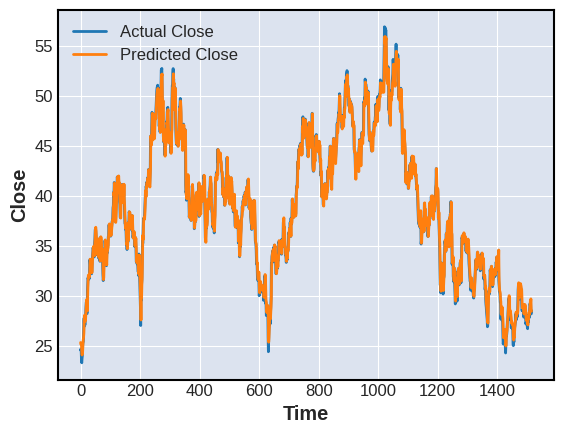

In [41]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [42]:
# Since we are not using .no_grad() here we will detatch it from the main graph then put it on cpu and flatten it
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

x = np.zeros((X_test.shape[0], lookback+1))
x[:, 0] = test_predictions
x = scaler.inverse_transform(x)

test_predictions = dc(x[:, 0])

In [43]:
# Now calculating the ground truth of the proper scale (y_test)

x = np.zeros((X_test.shape[0], lookback+1))
x[:, 0] = y_test.flatten()
x = scaler.inverse_transform(x)

new_ytest = dc(x[:,0])

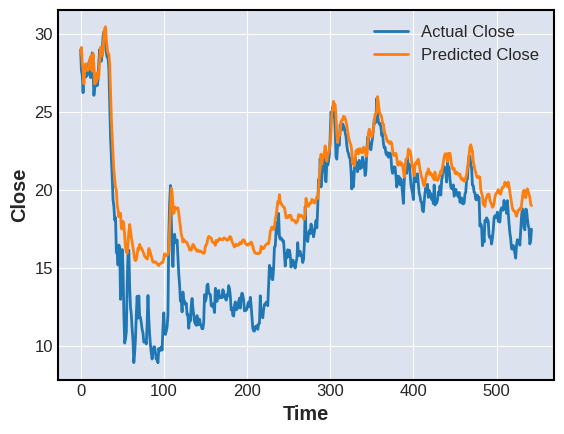

In [44]:
# Final graph

plt.plot(new_ytest, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

## Defining a simple trading module

In [45]:
#Since we will be making small fish trades as to not dissrupt the trend too much
exchange_limit = 2
stocks = 100 #Initial starting stock which we had before starting trading

In [46]:
profit = 0 #Profit variable
buy = np.zeros(len(new_ytest))
hold = np.zeros(len(new_ytest))
short = np.zeros(len(new_ytest))
threshold = 0.15 # For the transaction costs of making a transaction in stock market
for i in range(len(test_predictions)-1):
  if test_predictions[i+1] - test_predictions[i] > threshold:
    buy[i] = True
    hold[i] = False
    short[i] = False
    stocks += exchange_limit
    profit -= 2*new_ytest[i]*1.05
  elif test_predictions[i+1] - test_predictions[i] < -threshold and stocks > exchange_limit:
    buy[i] = False
    short[i] = True
    hold[i] = False
    profit += 2*new_ytest[i]*0.95
    stocks -= exchange_limit
  else:
    hold[i] = True
    buy[i] = False
    short[i] = False



In [47]:
# For buy and hold strategy
buy_hold = 100*(new_ytest[-1] - new_ytest[0])
print("Profit made from buy and hold strategy will be", buy_hold)
print("Profit made after using the model created will be", profit)

Profit made from buy and hold strategy will be -1150.2900769564512
Profit made after using the model created will be 177.27324925477447


So we can see that we make a profit when we use the model that we just created when compared to the buy and hold strategy

# References:
[1] https://pypi.org/project/mplfinance/

[2] https://www.youtube.com/watch?v=q_HS4s1L8UI

[3] https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

[4] https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fcolah.github.io%2Fposts%2F2015-08-Understanding-LSTMs%2F

- I've used google bard and chatgpt to understand some of the functions that I have used and to understand some concepts like buy sell spread and what is to be expected of the buy sell module for example.